# Video background removal

The frames of a video can be viewed as a superposition of a moving foreground to a steady background.
Splitting the background form the foreground can be a difficult task due to the continuous changes happening
in different areas of the frames. 

Firstly, the frames of a video needs to be loaded: the following database is loaded showing traffic of a busy [indian street](http://pione.dinf.usherbrooke.ca/static/dataset/clutter/IndianTraffic3.zip) taken from [http://scenebackgroundmodeling.net/](http://scenebackgroundmodeling.net/).

In [1]:
using Images, Printf

imgpath="data/IndianTraffic3/input/"
if !ispath(imgpath)
    file = download("http://pione.dinf.usherbrooke.ca/static/dataset/clutter/IndianTraffic3.zip")
    run(`unzip $file -d data/`)
end

img = load("$imgpath/in000000.jpg") # load first frame 
Frames = 900                      # number of frames in folder street
n,m = size(img,1),size(img,2)     # size of frames
frames = collect(1:135:Frames)    # select a slice of frames
l = length(frames)                # number of selected frames

Y = zeros(Float64,n,m,l)          #initialize data 

for f in eachindex(frames)
    a = @sprintf("%6.6i",frames[f])
    img = load("$imgpath/in$(a).jpg")
    Y[:,:,f] .= convert(Array{Float64},Gray.(img)) #loaf frames in B&W    
end

Y = reshape(Y,n*m,l); # Y contains the vectorized different frames in each of its coulmns

The following optimization problem can be posed to deal with such task:
 
$$ \underset{\mathbf{L},\mathbf{S}}{\text{minimize}} \tfrac{1}{2} \| \mathbf{L} + \mathbf{S} - \mathbf{Y} \|^2 + \lambda \| \text{vec}( \mathbf{S} ) \|_1  \ \text{s.t.} \ \text{rank}( \mathbf{L} ) \leq 1  $$

where $\mathbf{L} \in \mathbb{R}^{nm \times l}$ and $\mathbf{S} \in \mathbb{R}^{nm \times l}$ are matrices containing in each of their $l$-th columns the vectorized $l$-th frame of the background and of the foreground changes respectively. While in the former the frames are assumed to be constant and hence $\mathbf{L}$ can be represented by a _low rank matrix_, in the latter only the moving objects are present and $\mathbf{S}$ is then assumed to be a _sparse_ matrix. 

This problem is also known as _roboust principal component analysis (PCA)_.

`StructuredOptimization.jl` can solve the problem using the following syntax: 

In [2]:
using StructuredOptimization

L = Variable(n*m,l) #define variables
S = Variable(n*m,l)

lambda = 3e-2

@minimize ls(L+S-Y)+lambda*norm(S,1) st rank(L) <= 1 with PANOC(tol = 1e-4);


It is now possible to look at the results.


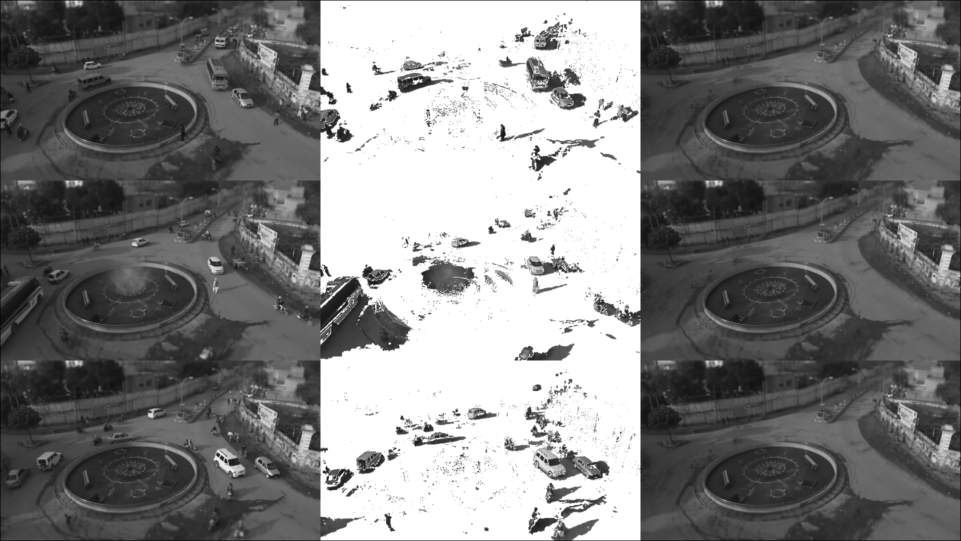

In [3]:
L = ~L # extract vectors from variables
S = ~S

S[ S .!= 0 ] .= S[ S .!= 0 ] .+L[ S .!= 0 ] # add background to foreground changes in nonzero elements
S[S.== 0] .= 1.0                            # put white in null pixels

Y = reshape(Y,n,m,l)
S = reshape(S,n,m,l)
L = reshape(L,n,m,l)

idx = [1;3;7]
img = Gray.(vcat([ [Y[:,:,i] S[:,:,i] L[:,:,i]] for i in idx]...))